In [1]:
import beatfinder
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
totensor = beatfinder.model.ToTensor(device)
print(f'Device: {device}')

Device: cuda


# Save datasets

In [2]:
# BALLROOM dataset

# Make a validation dataset
audio_files   = './data/BALLROOM/valid_audio_files.txt'
where_to_save = './data/saved-datasets/ballroom/valid/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# Make a training dataset
audio_files   = './data/BALLROOM/train_audio_files.txt'

# no augmentation
where_to_save = './data/saved-datasets/ballroom/train/normal'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# first augmented
where_to_save = './data/saved-datasets/ballroom/train/augmented_1'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# second augmented
where_to_save = './data/saved-datasets/ballroom/train/augmented_2'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# third augmented
audio_files   = './data/BALLROOM/train_audio_files.txt'
where_to_save = './data/saved-datasets/ballroom/train/augmented_3'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

In [29]:
# GTZAN dataset

# Make a validation dataset
audio_files   = './data/GTZAN/valid_audio_files.txt'
where_to_save = './data/saved-datasets/gtzan/valid/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# Make a training dataset
audio_files   = './data/GTZAN/train_audio_files.txt'

# no augmentation
where_to_save = './data/saved-datasets/gtzan/train/normal/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# augmented
where_to_save = './data/saved-datasets/gtzan/train/augmented_1/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# Load train and valid datasets

In [2]:
ballroom_validset      = beatfinder.datasets.AudioBeatsDataset(
                            file='./data/saved-datasets/ballroom/valid/dataset.ab')
ballroom_trainset_norm = beatfinder.datasets.AudioBeatsDataset(
                            file='./data/saved-datasets/ballroom/train/normal/dataset.ab')
ballroom_trainset_aug1 = beatfinder.datasets.AudioBeatsDataset(
                            file='./data/saved-datasets/ballroom/train/augmented_1/dataset.ab')
ballroom_trainset_aug2 = beatfinder.datasets.AudioBeatsDataset(
                            file='./data/saved-datasets/ballroom/train/augmented_2/dataset.ab')
ballroom_trainset_aug3 = beatfinder.datasets.AudioBeatsDataset(
                            file='./data/saved-datasets/ballroom/train/augmented_3/dataset.ab')
ballroom_trainset = ballroom_trainset_norm + ballroom_trainset_aug1

In [3]:
gtzan_validset      = beatfinder.datasets.AudioBeatsDataset(
                            file='./data/saved-datasets/gtzan/valid/dataset.ab')
gtzan_trainset_norm = beatfinder.datasets.AudioBeatsDataset(
                            file='./data/saved-datasets/gtzan/train/normal/dataset.ab')
gtzan_trainset_aug1 = beatfinder.datasets.AudioBeatsDataset(
                            file='./data/saved-datasets/gtzan/train/augmented_1/dataset.ab')
gtzan_trainset = gtzan_trainset_norm + gtzan_trainset_aug1
gtzan = gtzan_validset + gtzan_trainset

In [4]:
trainset = ballroom_trainset + gtzan
validset = ballroom_validset

# Check examples

In [13]:
dataset = trainset

4844/8022
         Name: reggae.00098.002
Song duration: 30.00
      Stretch: 1.0000
       Offset: 20.0000


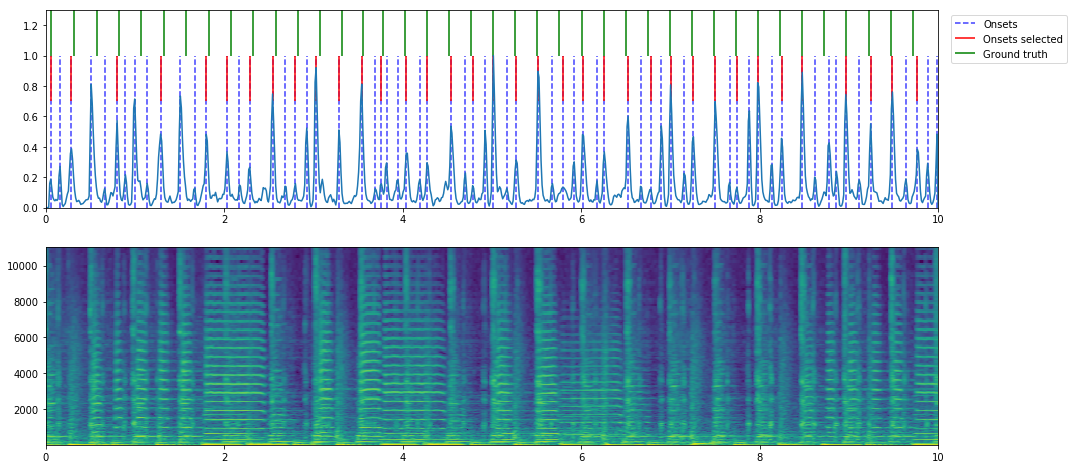

In [30]:
i = np.random.randint(len(dataset))
print(f'{i}/{len(dataset)}')
audiobeats = dataset[i]
print(f'         Name: {audiobeats.name}')
print(f'Song duration: {audiobeats.song_duration:.2f}')
print(f'      Stretch: {audiobeats.stretch:.4f}')
print(f'       Offset: {audiobeats.offset:.4f}')
beatfinder.display.showdata(audiobeats)

F measure: 1.00


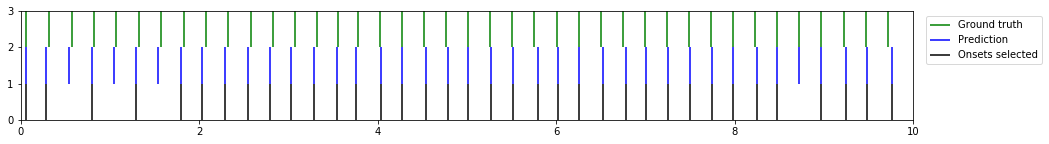

In [31]:
spec, onsets, isbeat, beats = audiobeats.get_data()
onsets_selected = beatfinder.utils.onsets_selected(onsets, isbeat)
pred_beats, bpm = beatfinder.utils.beat_track(onsets_selected, 300)
beatfinder.display.showprediction(beats, pred_beats, onsets_selected)
print(f'F measure: {beatfinder.utils.F_measure(beats, pred_beats):.2f}')

# Setup datasets for pytorch

In [5]:
totensor = beatfinder.model.ToTensor(device)
trainset.transform = totensor
validset.transform = totensor

# Find learning rate

In [33]:
model = beatfinder.model.BeatFinder()
model.to(device)

BeatFinder(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)

In [34]:
dataloader = DataLoader(trainset, batch_size=64, shuffle=True)
n_mb = len(dataloader) # number of mini batches
print(f'{n_mb} mini batches')
lr = (10. ** -np.arange(1, 5, 4 / n_mb))[::-1]

126 mini batches


In [35]:
losses = np.zeros(n_mb)
for i, (specs, onsets, isbeat) in enumerate(dataloader):
    model.set_lr(lr[i])
    tn, fp, fn, tp, loss = model.learn(specs, onsets, isbeat)
    losses[i] = loss
    print(f'{i + 1}/{n_mb}', end='\r')

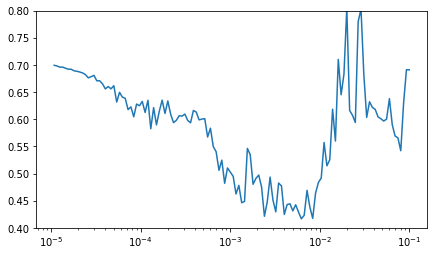

In [36]:
plt.figure(figsize=(7, 4))
plt.ylim(0.4, 0.8)
plt.semilogx(lr, losses);

# Train

In [6]:
model = beatfinder.model.BeatFinder()
model.to(device)
model.set_lr(0.0005)
print(model)
model.eval()
model.freeze()

BeatFinder(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)


In [7]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -----------------------
| tp:  7415 | fp: 13657 |
| fn:  1083 | tn:  1507 |
 -----------------------
 Accuracy: 0.3771
Precision: 0.3519
   Recall: 0.8726
F-measure: 0.5015
     Loss: 0.6954


In [8]:
model.unfreeze()
model.train();

In [9]:
train_hist, valid_hist = model.fit(trainset, validset, batch_size=64, epochs=10)

|  1 | L: 0.433 0.415 | F: 0.665 0.731 | A: 0.797 0.818 | 1.23 s/b | 0:02:35 | ETA: 0:23:19 |
|  2 | L: 0.357 0.478 | F: 0.759 0.678 | A: 0.845 0.766 | 1.28 s/b | 0:02:41 | ETA: 0:21:33 |
|  3 | L: 0.369 0.394 | F: 0.747 0.739 | A: 0.839 0.825 | 1.25 s/b | 0:02:38 | ETA: 0:18:26 |
|  4 | L: 0.359 0.450 | F: 0.753 0.714 | A: 0.844 0.796 | 1.26 s/b | 0:02:38 | ETA: 0:15:52 |
|  5 | L: 0.366 0.378 | F: 0.751 0.766 | A: 0.842 0.834 | 1.26 s/b | 0:02:38 | ETA: 0:13:14 |
|  6 | L: 0.332 0.354 | F: 0.781 0.783 | A: 0.860 0.846 | 1.31 s/b | 0:02:44 | ETA: 0:10:59 |
|  7 | L: 0.316 0.342 | F: 0.794 0.791 | A: 0.867 0.855 | 1.27 s/b | 0:02:40 | ETA: 0:08:01 |
|  8 | L: 0.303 0.341 | F: 0.805 0.795 | A: 0.874 0.855 | 1.29 s/b | 0:02:42 | ETA: 0:05:24 |
|  9 | L: 0.295 0.347 | F: 0.812 0.788 | A: 0.879 0.854 | 1.25 s/b | 0:02:37 | ETA: 0:02:37 |
| 10 | L: 0.292 0.403 | F: 0.811 0.759 | A: 0.878 0.829 | 1.28 s/b | 0:02:41 | ETA: 0:00:00 |


In [41]:
train_hist2, valid_hist2 = model.fit(trainset, validset, batch_size=64, epochs=10)

|  1 | L: 0.265 0.325 | F: 0.832 0.799 | A: 0.891 0.860 | 1.18 s/b | 0:02:29 | ETA: 0:22:23 |
|  2 | L: 0.269 0.295 | F: 0.828 0.824 | A: 0.889 0.874 | 1.21 s/b | 0:02:31 | ETA: 0:20:15 |
|  3 | L: 0.258 0.311 | F: 0.836 0.823 | A: 0.893 0.871 | 1.20 s/b | 0:02:30 | ETA: 0:17:35 |
|  4 | L: 0.279 0.321 | F: 0.823 0.798 | A: 0.885 0.861 | 1.19 s/b | 0:02:29 | ETA: 0:14:58 |
|  5 | L: 0.252 0.286 | F: 0.841 0.826 | A: 0.896 0.878 | 1.17 s/b | 0:02:26 | ETA: 0:12:14 |
|  6 | L: 0.291 0.309 | F: 0.808 0.814 | A: 0.877 0.870 | 1.15 s/b | 0:02:24 | ETA: 0:09:38 |
|  7 | L: 0.290 0.322 | F: 0.812 0.804 | A: 0.879 0.866 | 1.16 s/b | 0:02:26 | ETA: 0:07:18 |
|  8 | L: 0.261 0.301 | F: 0.836 0.826 | A: 0.893 0.874 | 1.16 s/b | 0:02:26 | ETA: 0:04:52 |
|  9 | L: 0.246 0.274 | F: 0.845 0.839 | A: 0.899 0.884 | 1.17 s/b | 0:02:27 | ETA: 0:02:27 |
| 10 | L: 0.254 0.418 | F: 0.839 0.754 | A: 0.896 0.831 | 1.17 s/b | 0:02:27 | ETA: 0:00:00 |


In [55]:
train_hist3, valid_hist3 = model.fit(trainset, validset, batch_size=64, epochs=5)

| 1 | L: 0.517 0.510 | F: 0.544 0.654 | A: 0.746 0.765 | 1.16 s/b | 0:02:25 | ETA: 0:09:43 |
| 2 | L: 0.413 0.405 | F: 0.703 0.757 | A: 0.815 0.823 | 1.15 s/b | 0:02:24 | ETA: 0:07:14 |
| 3 | L: 0.380 0.380 | F: 0.740 0.768 | A: 0.835 0.837 | 1.15 s/b | 0:02:25 | ETA: 0:04:50 |


KeyboardInterrupt: 

In [16]:
torch.save(model.state_dict(), './data/model_09.pt')

In [42]:
model.eval()
model.freeze()

In [48]:
a_train = np.zeros(10)
F_train = np.zeros(10)
a_valid = np.zeros(10)
F_valid = np.zeros(10)

for e in range(10):
    tn = np.sum(train_hist2[e, :, 0])
    fp = np.sum(train_hist2[e, :, 1])
    fn = np.sum(train_hist2[e, :, 2])
    tp = np.sum(train_hist2[e, :, 3])
    a, p, r, F = beatfinder.utils.measures(tn, fp, fn, tp)
    a_train[e] = a
    F_train[e] = F
    
    tn = valid_hist2[e, 0]
    fp = valid_hist2[e, 1]
    fn = valid_hist2[e, 2]
    tp = valid_hist2[e, 3]
    a, p, r, F = beatfinder.utils.measures(tn, fp, fn, tp)
    
    a_valid[e] = a
    F_valid[e] = F

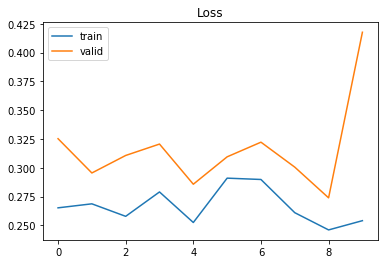

In [49]:
plt.plot(np.mean(train_hist2[:, :, 4], axis=1), label='train')
plt.plot(valid_hist2[:, 4], label='valid')
plt.title('Loss')
plt.legend();

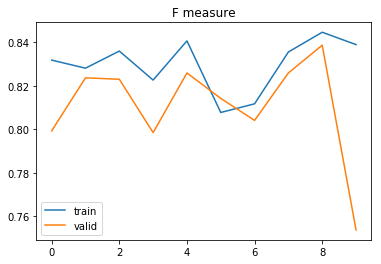

In [50]:
plt.plot(F_train, label='train')
plt.plot(F_valid, label='valid')
plt.title('F measure')
plt.legend();

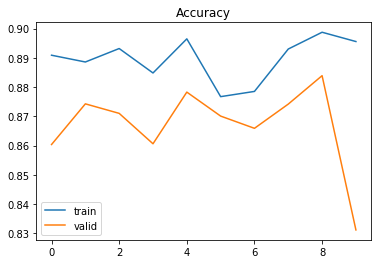

In [51]:
plt.plot(a_train, label='train')
plt.plot(a_valid, label='valid')
plt.title('Accuracy')
plt.legend();

In [52]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -----------------------
| tp:  6198 | fp:  1629 |
| fn:  2300 | tn: 13535 |
 -----------------------
 Accuracy: 0.8340
Precision: 0.7919
   Recall: 0.7293
F-measure: 0.7593
     Loss: 0.4143


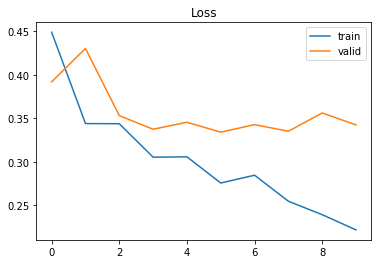

In [18]:
plt.plot(np.mean(train_hist[:, :, 4], axis=1), label='train')
plt.plot(valid_hist[:, 4], label='valid')
plt.title('Loss')
plt.legend();

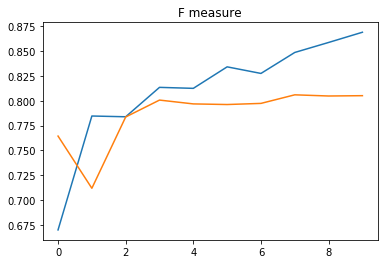

In [21]:
plt.plot(F_train, label='train')
plt.plot(F_valid, label='valid')
plt.title('F measure')
plt.legend();

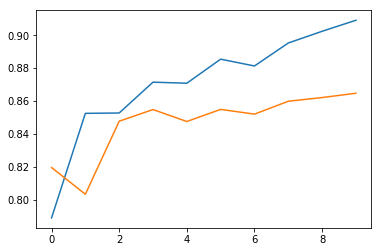

In [22]:
plt.plot(a_train, label='train')
plt.plot(a_valid, label='valid')
plt.title('Accuracy')
plt.legend();

In [23]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -----------------------
| tp:  6617 | fp:  1313 |
| fn:  1881 | tn: 13851 |
 -----------------------
 Accuracy: 0.8650
Precision: 0.8344
   Recall: 0.7787
F-measure: 0.8056
     Loss: 0.3509


# Import saved model

In [4]:
model = beatfinder.model.BeatFinder()
model.load_state_dict(torch.load('./data/pretrained-models/model_09.pt', map_location=device))
model.to(device)
model.eval()
model.freeze()

# Look at an example of a prediction

In [24]:
dataset = validset
dataset.transform = None

282/420


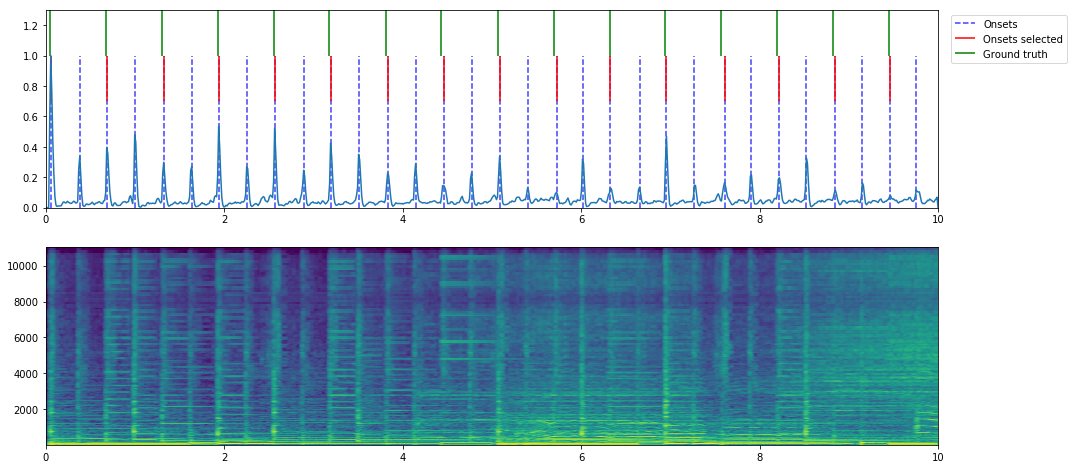

In [25]:
i = np.random.randint(len(dataset))
print(f'{i}/{len(dataset)}')
audiobeats = dataset[i]
beatfinder.display.showdata(audiobeats)

F measure: NaN


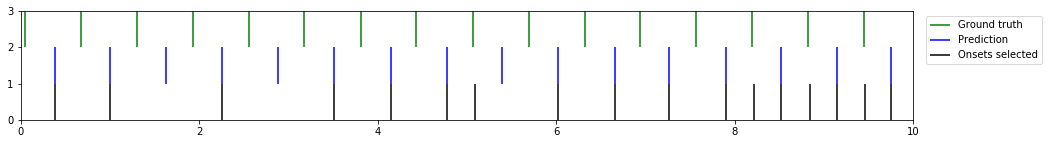

In [26]:
onsets_selected, beats_pred, bpm = beatfinder.utils.predict_beats(model, audiobeats, totensor)
beats = audiobeats.get_beats()
beatfinder.display.showprediction(beats, beats_pred, onsets_selected)
F = beatfinder.utils.F_measure(beats, beats_pred)
if F != None:
    print(f'F measure: {F:.2f}')
else:
    print('F measure: NaN')

# Evaluate a dataset

In [27]:
F, F_nan = beatfinder.utils.F_measure_from_dataset(model, dataset, totensor)
print()
print(f'F measure: {F:.2f}')
print(f'     NaNs: {F_nan}')

  0 :  NaN |   1 : 0.38 |   2 : 0.34 |   3 :  NaN |   4 :  NaN |   5 : 0.96 |   6 : 0.94 |   7 : 0.95 | 
  8 : 0.91 |   9 : 0.61 |  10 : 0.67 |  11 : 0.67 |  12 : 1.00 |  13 : 1.00 |  14 : 1.00 |  15 : 0.86 | 
 16 : 1.00 |  17 : 1.00 |  18 : 0.52 |  19 : 0.95 |  20 : 0.98 |  21 : 0.93 |  22 : 0.86 |  23 : 0.83 | 
 24 : 0.38 |  25 : 0.93 |  26 : 1.00 |  27 : 1.00 |  28 : 1.00 |  29 : 0.98 |  30 : 0.97 |  31 : 1.00 | 
 32 : 0.81 |  33 : 1.00 |  34 : 1.00 |  35 : 1.00 |  36 : 0.73 |  37 : 0.73 |  38 : 0.64 |  39 : 0.31 | 
 40 : 0.38 |  41 : 0.86 |  42 : 0.98 |  43 : 0.98 |  44 : 1.00 |  45 : 0.65 |  46 : 0.67 |  47 : 0.60 | 
 48 : 0.92 |  49 : 1.00 |  50 : 1.00 |  51 : 0.31 |  52 : 0.84 |  53 : 1.00 |  54 : 1.00 |  55 : 0.30 | 
 56 : 1.00 |  57 : 1.00 |  58 : 1.00 |  59 : 1.00 |  60 : 0.95 |  61 : 1.00 |  62 : 1.00 |  63 : 0.35 | 
 64 : 0.97 |  65 : 0.46 |  66 : 0.84 |  67 : 0.75 |  68 : 0.47 |  69 : 0.27 |  70 : 0.67 |  71 : 0.58 | 
 72 : 0.31 |  73 : 0.93 |  74 : 0.83 |  75 : 0.87 |  76